In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# UCI 데이터셋 가져오기
steel_industry_energy_consumption = fetch_ucirepo(id=851)

# 데이터와 타겟 분리
X = steel_industry_energy_consumption.data.features
y = steel_industry_energy_consumption.data.targets

# 메타데이터 및 변수 정보 출력 (선택사항)
print(steel_industry_energy_consumption.metadata)
print(steel_industry_energy_consumption.variables)


{'uci_id': 851, 'name': 'Steel Industry Energy Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/851/data.csv', 'abstract': 'The data is collected from a smart small-scale steel industry in South Korea.', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 35040, 'num_features': 9, 'feature_types': ['Real', 'Categorical'], 'demographics': [], 'target_col': ['Load_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2021, 'last_updated': 'Mon Aug 14 2023', 'dataset_doi': '10.24432/C52G8C', 'creators': ['Sathishkumar V E', 'Changsun Shin', 'Yongyun Cho'], 'intro_paper': {'title': 'Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city', 'authors': 'Sathishkumar V E, Changsun Shin, Yongyun Cho', 'published

In [2]:
from sklearn.preprocessing import OneHotEncoder

# 문자열 데이터를 one-hot encoding으로 변환
categorical_columns = ['WeekStatus', 'Day_of_week']  # 실제 열 이름에 맞게 수정
X_categorical = X[categorical_columns]
X_numerical = X.drop(columns=categorical_columns)

# OneHotEncoder를 사용하여 문자열 열을 인코딩
encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False로 수정
X_encoded = encoder.fit_transform(X_categorical)

# 인코딩된 열과 수치 데이터를 합침
X_combined = np.hstack((X_encoded, X_numerical.values))

# MinMaxScaler를 사용하여 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_combined)


In [3]:
# y를 Numpy 배열로 변환
y = y.values


In [4]:
# 시계열 데이터로 변환하기 위해 시퀀스 생성
time_steps = 10

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

# 데이터셋을 훈련, 검증, 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

In [5]:
# 만약 y_train 또는 y_test가 여전히 문자열이라면
if y_train.dtype == 'object' or y_test.dtype == 'object':
    try:
        y_train = y_train.astype(float)
        y_test = y_test.astype(float)
    except ValueError:
        from sklearn.preprocessing import LabelEncoder
        encoder = LabelEncoder()
        y_train = encoder.fit_transform(y_train)
        y_test = encoder.transform(y_test)


C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
876/876 [==============================] - 5s 4ms/step - loss: 0.2894 - mean_squared_error: 0.2894 - val_loss: 0.2174 - val_mean_squared_error: 0.2174
Epoch 2/100
876/876 [==============================] - 3s 4ms/step - loss: 0.2110 - mean_squared_error: 0.2110 - val_loss: 0.2249 - val_mean_squared_error: 0.2249
Epoch 3/100
876/876 [==============================] - 3s 4ms/step - loss: 0.1815 - mean_squared_error: 0.1815 - val_loss: 0.2061 - val_mean_squared_error: 0.2061
Epoch 4/100
876/876 [==============================] - 3s 4ms/step - loss: 0.1675 - mean_squared_error: 0.1675 - val_loss: 0.1812 - val_mean_squared_error: 0.1812
Epoch 5/100
876/876 [==============================] - 3s 4ms/step - loss: 0.1567 - mean_squared_error: 0.1567 - val_loss: 0.1999 - val_mean_squared_error: 0.1999
Epoch 6/100
876/876 [==============================] - 4s 4ms/step - loss: 0.1420 - mean_squared_error: 0.1420 - val_loss: 0.2005 - val_mean_squared_error: 0.2005
Epoch 7/100
876/876 [=

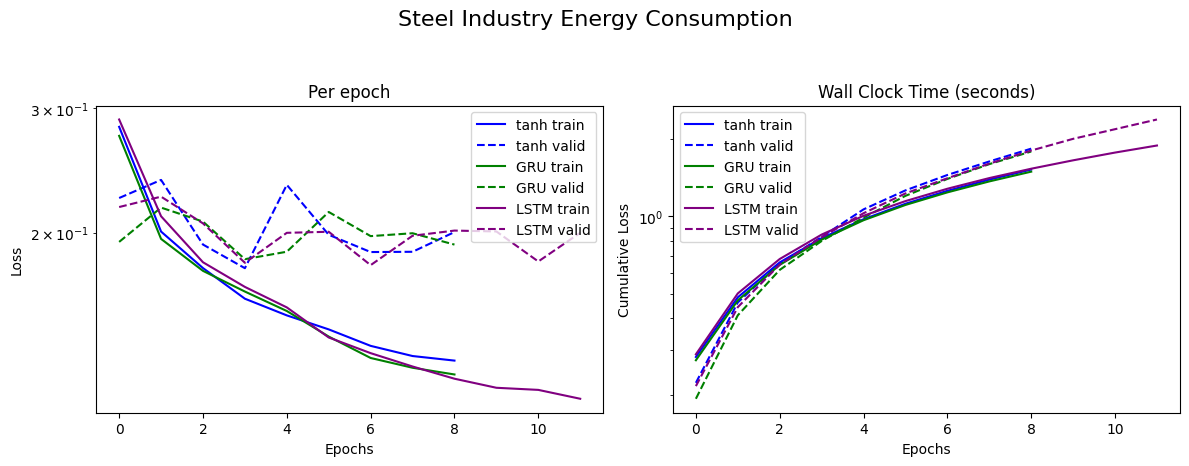

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping

# LSTM 모델 정의
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=RMSprop(), loss='mse', metrics=[MeanSquaredError()])
    return model

# GRU 모델 정의
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=RMSprop(), loss='mse', metrics=[MeanSquaredError()])
    return model

# SimpleRNN(tanh) 모델 정의
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=RMSprop(), loss='mse', metrics=[MeanSquaredError()])
    return model

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))
rnn_model = build_rnn_model((X_train.shape[1], X_train.shape[2]))

lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
gru_history = gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
rnn_history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

import matplotlib.pyplot as plt

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 8))

# Epochs 기준 그래프
plt.subplot(2, 2, 1)
plt.plot(rnn_history.history['loss'], label='tanh train', color='blue')
plt.plot(rnn_history.history['val_loss'], label='tanh valid', color='blue', linestyle='--')
plt.plot(gru_history.history['loss'], label='GRU train', color='green')
plt.plot(gru_history.history['val_loss'], label='GRU valid', color='green', linestyle='--')
plt.plot(lstm_history.history['loss'], label='LSTM train', color='purple')
plt.plot(lstm_history.history['val_loss'], label='LSTM valid', color='purple', linestyle='--')
plt.yscale('log')
plt.title('Per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 시간 기준 그래프
plt.subplot(2, 2, 2)
plt.plot(np.cumsum(rnn_history.history['loss']), label='tanh train', color='blue')
plt.plot(np.cumsum(rnn_history.history['val_loss']), label='tanh valid', color='blue', linestyle='--')
plt.plot(np.cumsum(gru_history.history['loss']), label='GRU train', color='green')
plt.plot(np.cumsum(gru_history.history['val_loss']), label='GRU valid', color='green', linestyle='--')
plt.plot(np.cumsum(lstm_history.history['loss']), label='LSTM train', color='purple')
plt.plot(np.cumsum(lstm_history.history['val_loss']), label='LSTM valid', color='purple', linestyle='--')
plt.yscale('log')
plt.title('Wall Clock Time (seconds)')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Loss')
plt.legend()

# 두 그래프를 합친 제목 추가
plt.suptitle('Steel Industry Energy Consumption', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle과 그래프가 겹치지 않도록 조정
plt.show()

1. Per epoch 그래프 (왼쪽 그래프)    

그래프 해석:
tanh 모델 (파란색): 초기 학습 속도가 빠르고, 훈련 손실은 계속해서 감소하고 있습니다. 그러나 검증 손실이 에포크가 진행됨에 따라 변동이 큰 패턴을 보이고 있습니다. 이는 모델이 과적합될 가능성이 있음을 시사합니다.  
GRU 모델 (녹색): GRU 모델의 손실은 학습과 검증 모두에서 안정적으로 감소하고 있습니다. 이는 모델이 데이터에 잘 적응하고 있으며, 일반화 성능이 우수함을 나타냅니다.  
LSTM 모델 (보라색): LSTM 모델 역시 손실이 안정적으로 감소하고 있으며, GRU와 유사한 성능을 보이고 있습니다. 다만, 검증 손실이 훈련 손실에 비해 더 낮게 유지되는 경향이 있습니다.  

2. Wall Clock Time 그래프 (오른쪽 그래프)

그래프 해석:
tanh 모델 (파란색): 이 모델은 다른 모델들에 비해 더 빠르게 손실을 누적시키는 경향이 있습니다. 이는 tanh 모델이 계산적으로 더 단순하고, 빠르게 학습을 완료할 수 있음을 의미합니다.   
GRU 모델 (녹색) 및 LSTM 모델 (보라색): 이 두 모델은 계산량이 많아 시간이 지남에 따라 손실이 천천히 누적됩니다. 이는 GRU와 LSTM 모델이 더 복잡한 계산을 수행하지만, 더 나은 성능을 얻기 위해 시간을 필요로 한다는 것을 의미합니다.  

종합 해석:
tanh 모델: 빠르게 학습하지만, 검증 손실이 변동이 큰 것으로 보아, 과적합될 가능성이 있습니다. 또한, 계산 효율이 좋지만, 성능 면에서는 다른 모델보다 다소 열세입니다.  
GRU 모델: 학습과 검증 손실이 모두 안정적이며, 모델이 데이터에 잘 적응하고 있음을 나타냅니다. 이는 일반화 성능이 우수하며, 안정적으로 성능을 낼 수 있는 모델임을 시사합니다.  
LSTM 모델: GRU와 유사한 성능을 보이며, 다소 더 복잡한 계산을 요구하지만, 성능 면에서는 GRU와 큰 차이가 없는 것으로 보입니다. 다만, GRU에 비해 학습 속도가 조금 더 느릴 수 있습니다.  

최종 결론:
GRU 모델이 가장 안정적이며, 일반화 성능이 우수해 보입니다.   
LSTM 모델도 유사한 성능을 제공하지만, 계산 자원이 더 많이 소요될 수 있습니다.     
tanh 모델은 빠르게 학습할 수 있지만, 과적합될 가능성이 있으며, 복잡한 문제에 대한 성능이 낮을 수 있습니다.  
따라서, 안정성과 성능을 고려했을 때, GRU가 가장 적합한 선택일 수 있습니다.  

In [7]:
from sklearn.metrics import mean_squared_error
# 모델 평가
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# MSE 계산
rnn_mse = mean_squared_error(y_test, rnn_pred)
lstm_mse = mean_squared_error(y_test, lstm_pred)
gru_mse = mean_squared_error(y_test, gru_pred)

print(f"RNN MSE: {rnn_mse}")
print(f"LSTM MSE: {lstm_mse}")
print(f"GRU MSE: {gru_mse}")

219/219 [==============================] - 1s 1ms/step
RNN MSE: 0.17803928482703324
LSTM MSE: 0.1798269137681717
GRU MSE: 0.18336860617167414


In [12]:
# LSTM 모델 정의
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])
    return model

# GRU 모델 정의
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])
    return model

# SimpleRNN(tanh) 모델 정의
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])
    return model


# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련 (조기 종료 콜백 추가)
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))
rnn_model = build_rnn_model((X_train.shape[1], X_train.shape[2]))

lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
gru_history = gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
rnn_history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# 6. 모델 평가
lstm_loss, lstm_mse = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_loss, gru_mse = gru_model.evaluate(X_test, y_test, verbose=0)
rnn_loss, rnn_mse = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Model - Test Loss: {lstm_loss}, Test MSE: {lstm_mse}")
print(f"GRU Model - Test Loss: {gru_loss}, Test MSE: {gru_mse}")
print(f"RNN Model - Test Loss: {rnn_loss}, Test MSE: {rnn_mse}")

# 학습 과정 시각화

plot_history(lstm_history, "LSTM Model Loss")
plot_history(gru_history, "GRU Model Loss")
plot_history(rnn_history, "RNN Model Loss")


Epoch 1/100


UnimplementedError: Graph execution error:

Detected at node 'mean_squared_error/Cast' defined at (most recent call last):
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\asb74\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\asb74\AppData\Local\Temp\ipykernel_42032\329567196.py", line 37, in <module>
      lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\asb74\anaconda3\envs\myenv\lib\site-packages\keras\losses.py", line 1469, in mean_squared_error
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'mean_squared_error/Cast'
Cast string to float is not supported
	 [[{{node mean_squared_error/Cast}}]] [Op:__inference_train_function_157964]

In [ ]:
from sklearn.metrics import mean_squared_error
# 모델 평가
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# MSE 계산
rnn_mse = mean_squared_error(y_test, rnn_pred)
lstm_mse = mean_squared_error(y_test, lstm_pred)
gru_mse = mean_squared_error(y_test, gru_pred)

print(f"RNN MSE: {rnn_mse}")
print(f"LSTM MSE: {lstm_mse}")
print(f"GRU MSE: {gru_mse}")